Kaggle: https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
TRAIN_DIR = './input/spam.csv'

# Explantory Data Analysis

In [3]:
df = pd.read_csv(TRAIN_DIR, encoding='latin-1') 

1.Take a Glance at the Data

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Prepare Data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

1.Split Training Set and Validation Set

In [6]:
X_train, X_val, y_train, y_val = train_test_split(list(df['v2']), list(df['v1']), test_size=0.2, random_state=0) 
print(f'Training Set: X_train Shape: {len(X_train)} | y_train Shape: {len(y_train)}')
print(f'Validation Set: X_val Shape: {len(X_val)} | y_val Shape: {len(y_val)}')

Training Set: X_train Shape: 4457 | y_train Shape: 4457
Validation Set: X_val Shape: 1115 | y_val Shape: 1115


In [7]:
X_train[0]

'No no:)this is kallis home ground.amla home town is durban:)'

2.Build Vocab

In [8]:
class tokenizer:
    def __init__(self, text_data):
        self.vocab = {}
        self.__get_vocab(text_data)
        
    def convert_text_dataset_to_matrix(self, X):
        vocab = self.vocab
        result = []       
        for text in tqdm(X):
            vector = self.__text_to_vector(text)
            result.append(vector)
        return result
    
    def __get_vocab(self, text_data):
        word_id = 0
        for text in text_data:
            words = text.split()
            for word in words:
                word = word.lower()
                if word not in self.vocab:
                    self.vocab[word] = word_id
                    word_id += 1
        print(f'Length of Dictionary: {len(self.vocab)}')
    
    def __text_to_vector(self, text):
        vocab = self.vocab
        result = list(np.zeros(len(vocab)))
        words = text.split()
        for word in words:
            word = word.lower()
            if word in vocab:
                result[vocab[word]] += 1
        return result

In [9]:
tz = tokenizer(X_train)

Length of Dictionary: 11706


In [10]:
X_train_matrix = tz.convert_text_dataset_to_matrix(X_train)
X_val_matrix = tz.convert_text_dataset_to_matrix(X_val)

100%|██████████| 1115/1115 [00:01<00:00, 711.72it/s]


# Model 1: Naive Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [12]:
def plot_confusion_matrix(conf_mtrx, classes, cmap=plt.cm.Blues):
    num_class = conf_mtrx.shape[0]
    
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mtrx, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(num_class), yticks=np.arange(num_class),
           xticklabels=classes, yticklabels=classes, 
           ylabel='True label', xlabel='Predicted label')

    middle_threshold = conf_mtrx.max() / 2.
    for row in range(num_class):
        for col in range(num_class):
            ax.text(col, row, format(conf_mtrx[row, col], '.0f'), ha="center", va="center",
                    color="white" if conf_mtrx[row, col] > middle_threshold else "black")
    fig.tight_layout()
    plt.show()

1.Fit

In [13]:
nb = MultinomialNB()
nb.fit(X_train_matrix, y_train)

MultinomialNB()

2.Predict

In [14]:
y_pred = nb.predict(X_val_matrix)

In [15]:
print('Accuracy: ', accuracy_score(y_val, y_pred))
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))
print('Classification Report')
print(classification_report(y_val, y_pred))

Accuracy:  0.9775784753363229
Confusion Matrix
[[948   1]
 [ 24 142]]
Classification Report
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       949
        spam       0.99      0.86      0.92       166

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



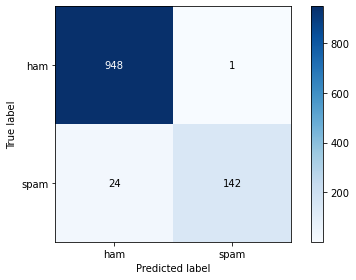

In [16]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred),classes=['ham', 'spam'])

# Model 2: Naive Bayes Model (No Sklearn)

1.Model Definition

In [17]:
class NaiveBayes_Spam:
    def __init__(self):
        self.log_p_spam_vector = None
        self.log_p_ham_vector = None
        self.log_p_spam = None
        self.log_p_ham = None
    
    def fit(self, X_train, y_train):
        num_text, num_words = len(X_train), len(X_train[0])
        spam_word_counter, ham_word_counter = np.ones(num_words), np.ones(num_words) # Laplace Smoothing
        spam_total_count, ham_total_count = 0, 0
        spam_count, ham_count = 0, 0
        
        for i in tqdm(range(num_text)):
            if y_train[i] == 'ham':
                ham_word_counter += X_train[i]
                ham_total_count += sum(X_train[i])
                ham_count += 1
            else:
                spam_word_counter += X_train[i]
                spam_total_count += sum(X_train[i])
                spam_count += 1
        
        # log p(x|spam) (With Laplace Smoothing): For all the words in spam emails,
        # the frequency of word x shows up.
        self.log_p_spam_vector = np.log(spam_word_counter \
             / (spam_total_count + num_words))
        # log p(x|ham)
        self.log_p_ham_vector = np.log(ham_word_counter \
             / (ham_total_count + num_words))
        # log p(spam)
        self.log_p_spam = np.log(spam_count / num_text) 
        # log p(ham)
        self.log_p_ham = np.log(ham_count / num_text) 
    
    def predict(self, X):
        num_text = len(X)
        result = []
        for i in tqdm(range(num_text)):
            log_p_spam = sum(X[i] * self.log_p_spam_vector) + self.log_p_spam
            log_p_ham = sum(X[i] * self.log_p_ham_vector) + self.log_p_ham
            if log_p_spam > log_p_ham:
                result.append('spam')
            else:
                result.append('ham')
        return result

2.Fit

In [18]:
nb = NaiveBayes_Spam()
nb.fit(X_train_matrix, y_train)

100%|██████████| 4457/4457 [00:13<00:00, 328.60it/s]


3.Predict

In [19]:
y_pred = nb.predict(X_val_matrix)

100%|██████████| 1115/1115 [00:10<00:00, 110.96it/s]


In [20]:
print('Accuracy: ', accuracy_score(y_val, y_pred))
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))
print('Classification Report')
print(classification_report(y_val, y_pred))

Accuracy:  0.9775784753363229
Confusion Matrix
[[948   1]
 [ 24 142]]
Classification Report
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       949
        spam       0.99      0.86      0.92       166

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



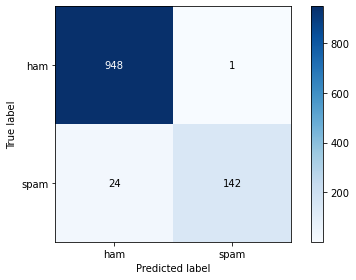

In [21]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred),classes=['ham', 'spam'])